In [ ]:
!pip install mxnet==1.6.0

     |████████████████████████████████| 68.7MB 45kB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx #Apache MXNet is an open-source deep learning software framework, used to train, and deploy deep neural networks.
import logging
from sklearn.metrics import accuracy_score
#from utils import generate_low_degree_g

/usr/local/lib/python2.7/dist-packages/mxnet/numpy_op_signature.py:61: UserWarning: Some mxnet.numpy operator signatures may not be displayed consistently with their counterparts in the official NumPy package due to too-low Python version 2.7.17 (default, Jul 20 2020, 15:37:01) 
[GCC 7.5.0]. Python >= 3.5 is required to make the signatures display correctly.
  .format(str(sys.version)))


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]

Saving utils.py to utils.py


In [ ]:
open('utils.py','wb').write(src)

In [ ]:
from utils import generate_low_degree_g

In [ ]:
from utils import plot_g, load_model

In [ ]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [ ]:
def calc_mahamtam_dis(G, tmp_node, node):
  p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']]
                 )
  p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
  #print(np.sqrt(np.sum((p_1 - p_2)**2)))
  #print(np.abs(p_1-p_2))
  #print(np.sum(np.abs(p_1 - p_2)))
  return np.sum(np.abs(p_1 - p_2))

In [ ]:
def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

In [ ]:
def generate_low_degree_g(num_nodes=100, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX, grid_size = 20000):
  G = nx.Graph()

  mahatam_coord = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
  coords_indices = list(range(grid_size))
  random.shuffle(coords_indices)
  x_coords = mahatam_coord[coords_indices][:num_nodes]
  random.shuffle(coords_indices)

  y_coords = mahatam_coord[coords_indices][:num_nodes]
  for node, coord in enumerate(zip(x_coords, y_coords)):
        G.add_node(node, x=coord[0], y=coord[1])

  for node in G.nodes:
    tmp_nodes = list(G.nodes)
    tmp_nodes.remove(node)
    node_dist = map(lambda tmp_node: (tmp_node, calc_mahamtam_dis(G, tmp_node, node) ), tmp_nodes)
    node_dist = sorted(node_dist, key=lambda d:d[1])

    num_of_neighbors = random.randint(min_out_degree, max_out_degree)
    for tmp_node in node_dist:
      if G.degree(tmp_node[0]) >= max_out_degree \
            or G.degree(node) >= num_of_neighbors:
            continue

      weight = random.uniform(weight_min, weight_max)
      geo_dist = calc_mahamtam_dis(G, tmp_node[0], node)
      G.add_edge(node, tmp_node[0], weight=weight * geo_dist)

  edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
  assert len(edge_centrality) == G.number_of_edges()
  for edge_data in G.edges.data():
    edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
  return G

In [ ]:
G = generate_low_degree_g()

In [ ]:
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]

In [ ]:
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())

4
2
100
172


In [ ]:
def plot_g(G, with_labels=True, node_size=300, font_size=8):
  pos = {}
  for t in G.nodes.items():
    pos[t[0]] = (t[1]['x'], t[1]['y'])

  nx.draw(G, pos=pos, node_size=node_size, font_size=font_size, with_labels = with_labels)
  plt.show()

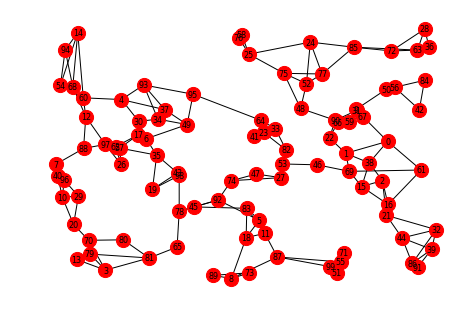

In [ ]:
plot_g(G, with_labels=True, node_size=200, font_size=8)

In [ ]:
from networkx import NetworkXNoPath

In [ ]:
def find_central_edge_greedy(G, start, depth=3):
    
    cur_node = start
    path = [cur_node]
    
    centrality_sum = 0.0
    
    for d in range(depth + 1):
        
        edge_tuples = map(lambda e:(e[0], e[1], G.get_edge_data(e[0], e[1])['centrality']),\
                  G.edges(cur_node))
        chosen_edge = max(edge_tuples, key=lambda t:t[2])
        
        assert cur_node == chosen_edge[0]
        cur_node = chosen_edge[1]
        
        # No point of getting trapped
        # in a dead loop;
        # just break out
        if cur_node in path:
            break
        
        centrality_sum += chosen_edge[2]
        path.append(cur_node)
    
    return centrality_sum

In [ ]:

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
        # Only look forward
        # allow look backwards(shouldn't be included)
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_mahamtam_dis(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

In [ ]:
def generate_stochastic_dataset(G, num_train_node_pairs=200,\
                                    num_test_node_pairs=50, verbose_frequence=50):
    
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []
    
    pair_path_dict = dict()
    
    train_selected_pairs = []
    test_selected_pairs = []
    num_of_nodes = G.number_of_nodes()
    
    train_mode = True
    
    while True:
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst:
            continue
        
        if (src, dst) in pair_path_dict:
            continue
        
        try:
            #shortest_path = nx.bellman_ford_path(G, src, dst)
            shortest_path = nx.dijkstra_path(G, src, dst)
            
                
        except NetworkXNoPath:
#                 print("No path between %d and %d" % (src, dst))
            continue
    
        for path in [shortest_path, shortest_path[::-1]]:
            
            src = path[0]
            dst = path[-1]
            
            pair_path_dict[(src, dst)] = path
            
            if train_mode and len(train_selected_pairs) < num_train_node_pairs:
                train_selected_pairs.append((src, dst))
            else:
                train_mode = False
                if len(test_selected_pairs) < num_test_node_pairs:
                    test_selected_pairs.append((src, dst))
                    
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

#  
                if train_mode:
                    train_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    train_labels.append(mid_node)
                else:
                    test_features.append(encode_edges(G, parent_node, cur_node, src, dst))
                    test_labels.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node
                
#                 sample_cnt += 1
                
#                 if sample_cnt % frequent == 0:
#                     print("Collected %d samples." % (sample_cnt))
        
#         print('len of train_selected_pairs: %d' % len(train_selected_pairs))
#         print('len of test_selected_pairs: %d' % len(test_selected_pairs))
        if len(train_selected_pairs) >= num_train_node_pairs \
            and len(test_selected_pairs) >= num_test_node_pairs:
            break
        
    return train_features, train_labels, test_features, test_labels, train_selected_pairs, test_selected_pairs, pair_path_dict

In [ ]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def augment_dataset(X, y, augmentation=False, augmentation_index=20, print_freq=3000):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            
            if augmentation:
                np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
#             if cnt % print_freq == 0:
#                 print("Processed %d samples" % (cnt))
            
    return X_aug, y_aug

In [ ]:
def generate_samples_from_graph(num_node_pairs, graph_size=100, augmentation=False, augmentation_index=1, label='Train'):
    
    G = generate_low_degree_g(num_nodes=graph_size)
    
#     plot_g(G, with_labels=True, node_size=200, font_size=8)
    
    features, labels, _, _, selected_pairs, _, pair_path_dict =\
            generate_stochastic_dataset(G, num_train_node_pairs=num_node_pairs, num_test_node_pairs=0)
        
    X, y = augment_dataset(features, labels,\
                           augmentation=augmentation,
                           augmentation_index=augmentation_index, \
                           print_freq=600)
    
    assert len(features) == len(labels)
#     assert len(y) == len(labels)
    assert len(X) == len(y)
    
    print(label)
    print("%d pairs are selected for training" % (len(selected_pairs)))
    print("len of pair_path_dict: %d" % (len(pair_path_dict)))
    print("Num of training sample: %d" % len(y))
    print(label)
    print('\n')
    
    return X, y, G, pair_path_dict

In [ ]:
X_train, y_train, G_train, _ = generate_samples_from_graph(num_node_pairs=100, augmentation=True, augmentation_index=10, label='Train')


Train
100 pairs are selected for training
len of pair_path_dict: 100
Num of training sample: 8940
Train




In [ ]:
X_val, y_val, G_val, _ = generate_samples_from_graph(num_node_pairs=20, augmentation=False, label='Validation')

Validation
20 pairs are selected for training
len of pair_path_dict: 20
Num of training sample: 204
Validation




In [ ]:
batch_size = 8

In [ ]:
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)

In [ ]:
val_iter = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)

In [ ]:
def build_model():
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=256)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    fc1 = mx.sym.Dropout(data=fc1)
    
    fc3  = mx.sym.FullyConnected(data=fc1, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp)

In [ ]:

model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
hist = model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 200),
#               epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=50)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:502: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


In [ ]:
X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=200, graph_size=20, augmentation=False, augmentation_index=1, label='Test')

KeyboardInterrupt: ignored

In [ ]:
pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=128)).asnumpy(), axis=1)

In [ ]:
acc = accuracy_score(y_test, pred_test)

In [ ]:
print("Accuracy on test set: %f" % (acc))

Accuracy on test set: 0.817629


In [ ]:
graph_sizes = [10, 50, 100, 200, 500]

In [ ]:
stats = [[] for _ in range(len(graph_sizes))]

In [ ]:
sample_size_stats = [[] for _ in range(len(graph_sizes))]

In [ ]:
number_of_tests = 2

In [ ]:
num_node_pairs = 10

In [ ]:
for idx, num_nodes in enumerate(graph_sizes):
    
    print('Working on graphs with %d nodes' % num_nodes)
    for i in range(number_of_tests):
            
        X_test, y_test, G_test, _ = generate_samples_from_graph(num_node_pairs=num_node_pairs, graph_size=num_nodes, augmentation=False, label='Test')

        pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test)).asnumpy(), axis=1)
        acc = accuracy_score(y_test, pred_test)
        stats[idx].append(acc)
        sample_size_stats[idx].append(len(y_test))

Working on graphs with 10 nodes
Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 22
Test


Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 14
Test


Working on graphs with 50 nodes
Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 42
Test


Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 96
Test


Working on graphs with 100 nodes
Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 102
Test


Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 88
Test


Working on graphs with 200 nodes
Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 112
Test


Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 130
Test


Working on graphs with 500 nodes
Test
10 pairs are selected for tra

In [ ]:
stats

[[0.9230769230769231,
  0.9333333333333333,
  0.9166666666666666,
  1.0,
  0.96875,
  0.75,
  0.875,
  0.875,
  0.85,
  1.0,
  1.0,
  1.0,
  0.8571428571428571],
 [0.926829268292683,
  0.875,
  0.7916666666666666,
  0.90625,
  0.8846153846153846,
  0.8846153846153846,
  0.7857142857142857,
  0.8645833333333334],
 [0.9178082191780822,
  0.8586956521739131,
  0.9102564102564102,
  0.8936170212765957,
  0.9457831325301205,
  0.8921568627450981,
  0.8409090909090909],
 [0.7894736842105263, 0.8839285714285714, 0.8692307692307693],
 [0.9026845637583892, 0.9183673469387755]]

In [ ]:
def nn_infer_next_node(G, path, parent, cur_node, src, dst, model, real_time_weight=False):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    assert max_degree == 4
    real_time_weight_change_factors = np.array([random.expovariate(lambd=1.0)\
                                                for _ in range(max_degree)])\
                                if real_time_weight else np.ones(max_degree)
    
    # change the weights of all edges
    input_vec[:, 1] = np.multiply(input_vec[:, 1], real_time_weight_change_factors)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
        #print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
            
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

In [ ]:
def bellford_path_finder(G, src, dst, p=0.0, model=None,\
                         invalid_path_threshold=G.number_of_nodes(),
                         real_time_weight=False):
  path = [src]
  parent_node = -1
  cur_node = src
  total_weights = .0
  while True:
    if len(path) >= invalid_path_threshold:
      return path, total_weights, False

    neigbors = list(G.neighbors(cur_node))
    num_neighbors = len(neigbors)
    pred_next_node, _ = nn_infer_next_node(G, path, parent_node,\
                                               cur_node, src, dst, model,\
                                               real_time_weight=real_time_weight)
    pred_next_idx = neigbors.index(pred_next_node)
    sample_probabilities = [p/(num_neighbors-1)\
                                for _ in range(num_neighbors)]
    sample_probabilities[pred_next_idx] = 1-p
    assert sum(sample_probabilities) <= 1.0 
    next_node = np.random.choice(neigbors, 1, p=sample_probabilities)[0]
    total_weights += G.get_edge_data(cur_node, next_node)['weight']
    path.append(next_node)
    if next_node == dst:
      return path, total_weights, True

    parent_node = cur_node
    cur_node = next_node

In [ ]:
def calc_path_weight_sum(G, path):
  weight_sum = 0.0
  for idx, node in enumerate(path[:-1]):
    weight_sum += G.edges[(node, path[idx + 1])]['weight']
    #print(idx)
    #print(node)
    if(idx == 4):
     weight_sum += 200
    if(idx == 8):
      weight_sum +=200

    if(idx == 20):
      weight_sum +=200
    if(idx == 12):
      weight_sum +=200
    if(idx == 30):
      weight_sum +=200
    if(idx == 50):
      weight_sum +=200
    if(idx == 40):
      weight_sum +=200
    #print(weight_sum)

  return weight_sum

In [ ]:
def calc_statistics(G, pair_path_dict, num_to_test=100, verbose=True):
  found_cnt = 0
  opt_path_cnt = 0
  edge_efficiency = {}
  time_efficiency = {}

  pairs = pair_path_dict.keys()

  random.shuffle(list(pairs))

  for src, dst in pairs[:num_to_test]:
    nn_path, _, found =  bellford_path_finder(G, src, dst, model=model, invalid_path_threshold=G.number_of_nodes())
    bellford_path = pair_path_dict[(src,dst)]

    if not found:
      continue

    found_cnt += 1
    edge_efficiency[(src, dst)] = float(len(bellford_path)-1) / (len(nn_path)-1)
    time_efficiency[(src, dst)] = calc_path_weight_sum(G, bellford_path) \
                                        / calc_path_weight_sum(G, nn_path)

    if nn_path == bellford_path:
      opt_path_cnt = opt_path_cnt + 1

    else:
      if verbose:
        print("The model is able to find a different path between %d and %d" % (src, dst))
        plot_bellford_nn_comparsion(G, bellford_path, nn_path)
        print("Dijsktra path :", bellford_path)
        print("NN path :", nn_path)
        print('')
  return found_cnt, opt_path_cnt, edge_efficiency, time_efficiency

In [ ]:
def print_paths_statistics(G, pair_path_dict, num_to_test=100, verbose=True):
  num_total_path = num_to_test
  found_cnt, opt_path_cnt, edge_efficiency, time_efficiency = calc_statistics(G,\
                                                                pair_path_dict=pair_path_dict,\
                                                                num_to_test=num_to_test,
                                                                verbose=verbose)
  print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
  print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
  print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))
    
  edge_efficiency_values = edge_efficiency.values()
  stat_mean = np.mean(edge_efficiency_values)
  stat_std = np.std(edge_efficiency_values)
    
  label = u'%d pairs, μ=%f, σ=%f' % \
          (len(edge_efficiency), stat_mean, stat_std)
  print(label)
    
  time_efficiency_values = time_efficiency.values()
  print("Time Effiency",time_efficiency)
  stat_mean = np.mean(time_efficiency_values)
  stat_std = np.std(time_efficiency_values)
    
  label = u'%d pairs, μ=%f, σ=%f' % \
          (len(time_efficiency), stat_mean, stat_std)
  print(label)

In [ ]:
def plot_bellford_nn_comparsion(G, bellford_node_list, nn_node_list):

    pos = {}

    for node in bellford_node_list:
        pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    bellford_edge_list = []
    for idx, node in enumerate(bellford_node_list[:-1]):
        bellford_edge_list.append((node, bellford_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=pos, edgelist=bellford_edge_list, node_size=20, edge_color='r')
    nn_pos = {}

    for node in nn_node_list:
        nn_pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])

    nn_edge_list = []
    for idx, node in enumerate(nn_node_list[:-1]):
        nn_edge_list.append((node, nn_node_list[idx+1]))

    nx.draw_networkx_edges(G, pos=nn_pos, edgelist=set(nn_edge_list), node_size=100, edge_color='b')
    
    nx.draw_networkx_nodes(G, pos=pos,\
                           nodelist=[bellford_node_list[0], bellford_node_list[-1]],\
                           node_size=10,\
                           node_color=['r', 'g'])
    
    plt.legend(loc='best')
    plt.show()

In [ ]:
num_node_pairs = 10

In [ ]:
_, _, G_test, pair_path_dict = generate_samples_from_graph(num_node_pairs=num_node_pairs,\
                                                           graph_size=100,\
                                                           augmentation=False,\
                                                           label='Test')

Test
10 pairs are selected for training
len of pair_path_dict: 10
Num of training sample: 72
Test




The model is able to find a different path between 85 and 51


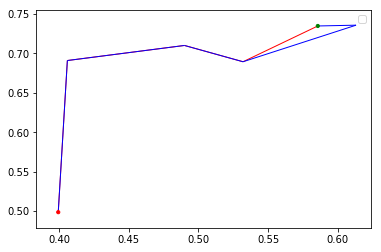

('Dijsktra path :', [85, 66, 25, 8, 51])
('NN path :', [85, 66, 25, 8, 40, 51])

The model is able to find a different path between 10 and 82


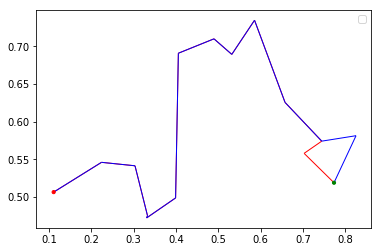

('Dijsktra path :', [10, 16, 37, 57, 77, 85, 66, 25, 8, 51, 90, 30, 18, 82])
('NN path :', [10, 16, 37, 57, 77, 85, 66, 25, 8, 51, 90, 30, 12, 82])



The model is able to find a different path between 48 and 27


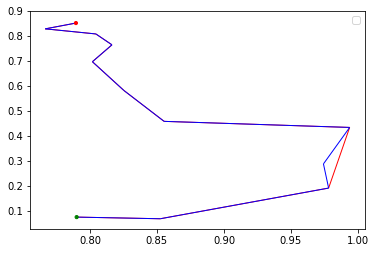

('Dijsktra path :', [48, 42, 54, 7, 97, 12, 75, 46, 81, 84, 27])
('NN path :', [48, 42, 54, 7, 97, 12, 75, 46, 64, 81, 84, 27])

The model is able to find a different path between 55 and 76


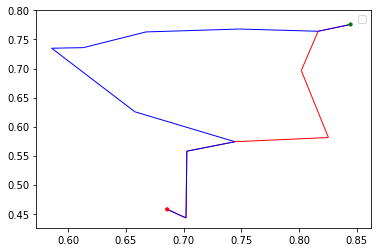

('Dijsktra path :', [55, 33, 18, 30, 12, 97, 7, 76])
('NN path :', [55, 33, 18, 30, 90, 51, 40, 6, 53, 7, 76])

8 out of 10 can find path: 0.800000
4 out of 8 can find optimal path: 0.500000
4 out of 10 all paths can find optimal paths: 0.400000
8 pairs, μ=0.926136, σ=0.108753
('Time Effiency', {(15, 81): 1.0, (81, 15): 1.0, (10, 82): 0.9999236739650278, (48, 27): 0.9999119608710524, (55, 76): 0.5003606987125928, (76, 55): 1.0, (51, 85): 1.0, (85, 51): 0.001389494357267467})
8 pairs, μ=0.812698, σ=0.347528


In [ ]:
print_paths_statistics(G_test,num_to_test=num_node_pairs,pair_path_dict=pair_path_dict )